In [1]:
import warnings
warnings.filterwarnings('ignore')

### Prepare Experiment Data

In [2]:
from spider_env import SpiderEnv

spider = SpiderEnv(cache_dir='spider')

# select a random question in Spider
observation, info = spider.reset()
question = observation["instruction"]
print('question:', question)
print('gold query:', info['gold_query'])
print('gold result:', info['gold_result'])

Loading cached Spider dataset from spider
Schema file not found for spider/spider/database/company_1
Schema file not found for spider/spider/database/epinions_1
Schema file not found for spider/spider/database/twitter_1
Schema file not found for spider/spider/database/icfp_1
Schema file not found for spider/spider/database/flight_4
Schema file not found for spider/spider/database/small_bank_1
Schema file not found for spider/spider/database/chinook_1
question: Find the famous titles of artists that do not have any volume.
gold query: SELECT Famous_Title FROM artist WHERE Artist_ID NOT IN(SELECT Artist_ID FROM volume)
gold result: [('Antievangelistical Process (re-release)',), ('Antithesis of All Flesh',)]


### Prepare LLM

In [3]:
import json
import os
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from semantic_search_tools import SemanticSearchTool

os.environ['OPENAI_API_KEY'] = 'your-openai-api-key'
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Notes: you can expand n_results to make sure the search results cover final tables, e.g., n_results=50
db_schema_search_tool = SemanticSearchTool(n_results=10)

### Prepare memory cache

In [4]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

### Prepare Agents

In [5]:
from typing import TypedDict

class AgentState(TypedDict):
    question: str
    table_schemas: str
    database: str
    sql: str
    reflect: str
    accepted: bool
    revision: int
    max_revision: int

In [6]:
with open('agents/langgraph.json') as f:
    agent_config = json.load(f)

def search_engineer_node(state: AgentState):
    candidates = db_schema_search_tool(state['question'])
    role_prompt = agent_config['search_engineer']
    messages = [
        SystemMessage(content=role_prompt['system']), 
        HumanMessage(
            content=f"Based on the following candidate database/table schemas:\n{candidates}\n\n"
            f"Find the relevant database/table schemas to answer the question: {state['question']}\n\n{role_prompt['expected_output']}")
    ]
    response = model.invoke(messages)
    json_output = json.loads(response.content)
    return {"table_schemas": json_output['table_schemas'], "database": json_output['database']}

def senior_sql_writer_node(state: AgentState):
    role_prompt = agent_config['senior_sql_writer']
    messages = [
        SystemMessage(content=role_prompt['system']), 
        HumanMessage(
            content=f"Based on the following database/table schemas:\n{state['table_schemas']}\n\n"
            f"Write a SQL script to answer the question: {state['question']}\n\n{role_prompt['expected_output']}")
    ]
    response = model.invoke(messages)
    return {"sql": response.content, "revision": state['revision']+1}

def senior_qa_engineer_node(state: AgentState):
    role_prompt = agent_config['senior_qa_engineer']
    messages = [
        SystemMessage(content=role_prompt['system']), 
        HumanMessage(
            content=f"Based on the following database/table schemas:\n{state['table_schemas']}\n\n"
            f"And the sql script:\n{state['sql']}\n\n"
            f"Verify the sql script to check if it can complete the task: {state['question']}\n\n{role_prompt['expected_output']}")
    ]
    response = model.invoke(messages)
    return {"accepted": 'ACCEPTED' in response.content.upper()}

def chief_dba_node(state: AgentState):
    role_prompt = agent_config['chief_dba']
    messages = [
        SystemMessage(content=role_prompt['system']), 
        HumanMessage(
            content=f"Based on the following database/table schemas:\n{state['table_schemas']}\n\n"
            f"And the imperfect sql script:\n{state['sql']}\n\n"
            f"Provide the usefule and detail recommendation to help the sql writer complete the task: {state['question']}\n\n{role_prompt['expected_output']}")
    ]
    response = model.invoke(messages)
    return {"reflect": response.content}

### Construct Graph

In [7]:
builder = StateGraph(AgentState)

# add nodes
builder.add_node("search_engineer", search_engineer_node)
builder.add_node("sql_writer", senior_sql_writer_node)
builder.add_node("qa_engineer", senior_qa_engineer_node)
builder.add_node("chief_dba", chief_dba_node)

# add edges
builder.add_edge("search_engineer", "sql_writer")
builder.add_edge("sql_writer", "qa_engineer")
builder.add_edge("chief_dba", "sql_writer")

# add conditional edges
builder.add_conditional_edges(
    "qa_engineer", 
    lambda state: END if state['accepted'] == True or state['revision'] >= state['max_revision'] else "reflect", 
    {END: END, "reflect": "chief_dba"}
)

# set entry point
builder.set_entry_point("search_engineer")

# compile graph
graph = builder.compile(checkpointer=memory)

### Visualize the Graph

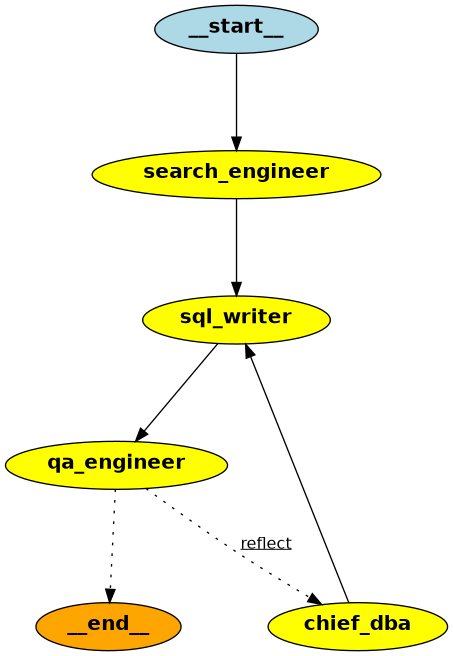

In [8]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

### Run the Graph

In [9]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'question': question,
    'accepted': False,
    "revision": 0,
    "max_revisions": 2
}, thread):
    print(s)

{'search_engineer': {'table_schemas': [{'table': 'artist', 'schema': 'CREATE TABLE "artist" (\n"Artist_ID" int,\n"Artist" text,\n"Age" int,\n"Famous_Title" text,\n"Famous_Release_date" text,\nPRIMARY KEY ("Artist_ID")\n)'}, {'table': 'volume', 'schema': 'CREATE TABLE "volume" (\n"Volume_ID" int,\n"Volume_Issue" text,\n"Issue_Date" text,\n"Weeks_on_Top" real,\n"Song" text,\n"Artist_ID" int,\nPRIMARY KEY ("Volume_ID"),\nFOREIGN KEY (`Artist_ID`) REFERENCES `artist`(`Artist_ID`)\n)'}], 'database': 'music_4'}}
{'sql_writer': {'sql': '```sql\nSELECT DISTINCT a."Famous_Title"\nFROM artist a\nLEFT JOIN volume v ON a."Artist_ID" = v."Artist_ID"\nWHERE v."Artist_ID" IS NULL;\n```', 'revision': 1}}
{'qa_engineer': {'accepted': True}}


In [10]:
print('database:', graph.get_state(thread).values['database'])
print('sql:\n', graph.get_state(thread).values['sql'])

database: music_4
sql:
 ```sql
SELECT DISTINCT a."Famous_Title"
FROM artist a
LEFT JOIN volume v ON a."Artist_ID" = v."Artist_ID"
WHERE v."Artist_ID" IS NULL;
```


### Compare with gold result

In [11]:
import sqlite3

database = graph.get_state(thread).values['database']
con = sqlite3.connect(f'spider/spider/database/{database}/{database}.sqlite')
cursor = con.cursor()
cursor.execute("""SELECT a."Famous_Title"
FROM "artist" a
LEFT JOIN "volume" v ON a."Artist_ID" = v."Artist_ID"
WHERE v."Volume_ID" IS NULL;""")
results = cursor.fetchall()
print(results)

[('Antievangelistical Process (re-release)',), ('Antithesis of All Flesh',)]


In [12]:
print(info['gold_result'])

[('Antievangelistical Process (re-release)',), ('Antithesis of All Flesh',)]
